In [ ]:
import os
import csv
import torch
import torch.nn as nn
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, MNIST, SVHN
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import auc, f1_score, precision_recall_curve, roc_auc_score, roc_curve
!pip install git+https://github.com/aleju/imgaug.git
import imgaug.augmenters as iaa
import glob
import os.path as path
import PIL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-qus88ilt
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-qus88ilt


# Retrain with Resnet50 Backbone with OpenGAN with BatchNorm like original implementation

# Then I can validate using more than just MNIST
# Validate on SVHN vs TinyImageNet

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Unknown_Detection/tiny-imagenet-200.zip","r") as zip_ref:
    zip_ref.extractall()

In [ ]:
class Closed_TINYIMAGENET():
    def __init__(self, size=(32,32), set_name='train',
                 path_to_data='/content/tiny-imagenet-200', 
                 isAugment=True):
        
        self.path_to_data = path_to_data        
        self.mapping_name2id = {}
        self.mapping_id2name = {}
        self.mapping_name2english_name = {}
        with open(path.join(self.path_to_data, 'wnids.txt')) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=' ')
            idx = 0
            for row in csv_reader:
                if idx >= 180: 
                  break
                self.mapping_id2name[idx] = row[0]
                self.mapping_name2id[row[0]] = idx
                idx += 1
        with open(path.join(self.path_to_data, 'words.txt')) as csv_file: 
          csv_reader = csv.reader(csv_file, delimiter=' ')
          idx = 0
          for row in csv_reader:
            row = row[0].split('\t')
            self.mapping_name2english_name[row[0]] = row[1]
            idx += 1


        assert len(self.mapping_id2name) == len(self.mapping_name2id) == 180
        
        
        if set_name=='test':  set_name = 'val'
        
        self.size = size
        self.set_name = set_name
        self.path_to_data = path_to_data
        self.isAugment = isAugment
        
        self.imageNameList  = []
        self.className = []
        self.labelList = []
        self.mappingLabel2Name = dict()
        curLabel = 0

        
        if self.set_name == 'val':
            with open(path.join(self.path_to_data, 'val', 'val_annotations.txt')) as csv_file:
                csv_reader = csv.reader(csv_file, delimiter='\t')
                line_count = 0
                for row in csv_reader:
                    if row[1] not in self.mapping_name2id: continue
                    self.imageNameList += [path.join(self.path_to_data, 'val', 'images', row[0])]
                    self.labelList += [self.mapping_name2id[row[1]]]
        else: # 'train'
            self.current_class_dir = path.join(self.path_to_data, self.set_name)
            for curClass in os.listdir(self.current_class_dir):                 
                if curClass[0]=='.':   continue
                if curClass not in self.mapping_name2id: continue
                
                curLabel = self.mapping_name2id[curClass]
                for curImg in os.listdir(path.join(self.current_class_dir, curClass, 'images')):
                    if curImg[0]=='.':    continue
                    self.labelList += [curLabel]
                    self.imageNameList += [path.join(self.path_to_data, self.set_name, curClass, 'images', curImg)]

        
        self.current_set_len = len(self.labelList)
        
        if self.set_name=='test' or self.set_name=='val' or  not self.isAugment:
            self.transform = transforms.Compose([
                transforms.RandomCrop(self.size[0], padding=4), 
                transforms.ToTensor(),
                transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262)),
            ])            # ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        else:
            self.transform = transforms.Compose([
                transforms.RandomCrop(self.size[0], padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262)),
            ])
        
    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):
        curLabel = np.asarray(self.labelList[idx])
        curImage = self.imageNameList[idx]
        curImage = PIL.Image.open(curImage).convert('RGB')
        curImage = self.transform(curImage)
        
        #print(idx, curLabel)
        
        #curLabel = torch.tensor([curLabel]).unsqueeze(0).unsqueeze(0)

        return curImage, curLabel

Length of trainTinyImageNet is 90000
Length of testTinyImageNet is 9000
(32, 3, 32, 32)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


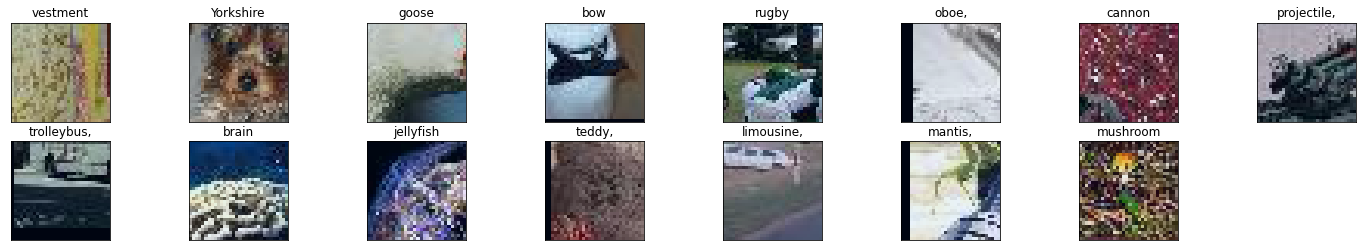

In [ ]:
batch_size = 32

trainTinyImageNet = Closed_TINYIMAGENET(set_name = 'train')
trainTinyImageNetLoader = torch.utils.data.DataLoader(trainTinyImageNet, batch_size = 32, shuffle = True)
print("Length of trainTinyImageNet is {}".format(len(trainTinyImageNet)))

testTinyImageNet = Closed_TINYIMAGENET(set_name = 'test')
testTinyImageNetLoader = torch.utils.data.DataLoader(testTinyImageNet, batch_size = 32, shuffle = True)
print("Length of testTinyImageNet is {}".format(len(testTinyImageNet)))

# Plot train images
train_dataiter = iter(trainTinyImageNetLoader)
images, targets = next(train_dataiter)
assert max(targets) < 180
images = images.numpy()
print(images.shape)
images -= images.min() 
images /= images.max()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(15):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title(trainTinyImageNet.mapping_name2english_name[trainTinyImageNet.mapping_id2name[targets[idx].item()]])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])

In [ ]:
# Metrics: 

def F_measure(preds, labels, openset=False, theta=None):
  if openset:
      # f1 score for openset evaluation
      true_pos = 0.
      false_pos = 0.
      false_neg = 0.        
      for i in range(len(labels)):
          true_pos += 1 if preds[i] == labels[i] and labels[i] != -1 else 0
          false_pos += 1 if preds[i] != labels[i] and labels[i] != -1 else 0
          false_neg += 1 if preds[i] != labels[i] and labels[i] == -1 else 0

      precision = true_pos / (true_pos + false_pos)
      recall = true_pos / (true_pos + false_neg)
      return 2 * ((precision * recall) / (precision + recall + 1e-12))
  else: # Regular f1 score        
      return f1_score(labels, preds, average='macro')

def roc(scores, labels, **kwargs):
    """Returns the ROC curve and the area under it. The implementation assumes binary classification

    Args:
        labels (np.array): denotes label for each data point
        scores (np.array): denotes predicted probability of data point being 1
    """
    if 'gt_shift' in kwargs:
        labels = labels - kwargs['gt_shift']
    fpr, tpr, thresholds = roc_curve(labels, scores)
    auc_score = roc_auc_score(labels, scores)
    roc_data = {
        'tp': list(tpr),
        'fp': list(fpr),
        'thresh': list(thresholds),
        'auc': auc_score,
    }
    return roc_data


def pr(scores, labels, **kwargs):
    """Returns the PR curve and the area under it. The implementation assumes binary classification

    Args:
        labels (np.array): denotes label for each data point
        scores (np.array): denotes predicted probability of data point being 1
    """
    precision, recall, thresholds = precision_recall_curve(labels, scores)
    auc_score = auc(recall, precision)

    pr_data = {
        'precision': list(precision),
        'recall': list(recall),
        'thresh': list(thresholds),
        'auc': auc_score,
    }
    return pr_data

def ccr(scores, labels, **kwargs):
    """Returns the CCR VS FPR curve and returns the area under it.

    Args:
        labels (np.array): denotes label for each data point
        scores (np.array): denotes predicted probability of data point being 1
    """
    if 'gt_shift' in kwargs:
        labels = labels - kwargs['gt_shift']
    max_indices = np.argmax(scores, axis=1) # Nx(K+1)
    max_values = np.take_along_axis(scores, max_indices[:, None], axis=1)
    data = list(zip([elem[0] for elem in max_values], max_indices, labels))
    data.sort(key=lambda x: x[0], reverse=True)
    cls_count = len(scores[0])
    unknown_count = len(np.where(labels == 0)[0])  # Unknown class is 0
    known_count = len(labels) - unknown_count
    fp = [0]
    tp = [0]
    thresholds = list()
    n = 0
    n_above_unknown = 0
    curr_unknown_prob = 1
    for score, pred_cls, gt_cls in data:
        if gt_cls == 0:
            curr_unknown_prob = score
            thresholds.append(score)
            fp.append(fp[-1] + 1)
            tp.append(n)
        elif pred_cls == gt_cls:
            n_above_unknown += 1
            if score < curr_unknown_prob:
                n = n_above_unknown
    fpr = np.asarray(fp[1:]) / unknown_count
    ccr = np.asarray(tp[1:]) / known_count
    auc_score = auc(fpr, ccr)
    ccr_data = {
        'ccr': list(ccr),
        'fpr': list(fpr),
        'thresh': thresholds,
        'auc': auc_score,
    }
    return ccr_data
    

In [ ]:
# Define resnet Model
#resnet50 = torchvision.models.resnet50(pretrained = True)
# for param in resnet50.parameters(): 
#   param.requires_grad = False
#resnet50.fc = nn.Linear(resnet50.fc.in_features, 180)

resnet50 = models.resnet50(pretrained=False)

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 180)

# resnet18 = torchvision.models.resnet18()
# resnet18.fc = nn.Linear(resnet18.fc.in_features, 180)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
epochs = 50
def cosine_annealing(step, total_steps, lr_max, lr_min):
    return lr_min + (lr_max - lr_min) * 0.5 * (
            1 + np.cos(step / total_steps * np.pi))
    
# Add validation on 4 other classes. 


def train(net, epochs, folder_weights):

  if os.path.exists(folder_weights): 
    raise RuntimeError("Folder already exists")

  os.mkdir(folder_weights)

  top_paths = dict()

  lr = 0.003 # lower learning rate: 0.003
  net = net.cuda()
  optimizer = torch.optim.SGD(
  net.parameters(), lr, momentum=0.9, 
  weight_decay=0.0005, nesterov=True)

  scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: cosine_annealing(
        step,
        epochs * len(trainTinyImageNetLoader),
        1,  # since lr_lambda computes multiplicative factor
        1e-6 / lr))
  
  model_path = ""
  for e in range(epochs): 
    correct = 0
    num_of_data = 0
    total_f_measure = 0
    model_path = os.path.join(folder_weights, "model_epoch{}.pth".format(e))
    net.train()  # enter train mode
    loss_avg = 0.0
    for data, target in tqdm(trainTinyImageNetLoader):
        data, target = data.cuda(), target.cuda()

        # forward
        x = net(data)

        # backward
        scheduler.step()
        optimizer.zero_grad()
        loss = F.cross_entropy(x, target)
        loss.backward()
        optimizer.step()

        # exponential moving average
        loss_avg = loss_avg * 0.8 + float(loss) * 0.2

    stacked_pred = list()
    stacked_target = list()
    for data, target in tqdm(testTinyImageNetLoader): 
      
      net.eval()
      num_of_data += data.size(0)
      data, target = data.cuda(), target.cuda()

      #forward
      x = net(data)
      prob = F.softmax(x, dim=1)
      assert sum(prob[0]).item() > 0.99 and sum(prob[0]).item() < 1.001

      pred = torch.argmax(prob, dim = 1)

      stacked_pred.extend(pred.tolist())
      stacked_target.extend(target.tolist())
      correct += torch.sum(pred == target)

    f_measure = F_measure(stacked_pred, stacked_target) * 100
    accuracy = (correct / num_of_data) * 100

    top_paths[model_path] = "{} f_measure, {} accuracy".format(f_measure, accuracy)
    
    print("Epoch: {}".format(e))
    print("Loss Avg: {}".format(loss_avg))
    print("Last Learning Rate: {}".format(scheduler.get_last_lr()))
    print("Accuracy: {}%".format(accuracy))
    print("F measure: {}%".format(f_measure))

    if (e % 5 == 0) and (e != 0): 
      torch.save(net.state_dict(), model_path)
      print("Model saved...")
    
  with open("model_weightsLOGS.txt", 'a+') as f:
    for k in top_paths.keys():
      final_string = '{} : {}'.format(k, top_paths[k]) 
      print(final_string, file=f)

  return net

In [ ]:
final_model = train(resnet50, epochs, "SeptModelNoPretrained")

  0%|          | 0/2813 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 282/282 [00:09<00:00, 29.88it/s]


Epoch: 0
Loss Avg: 4.768987653928306
Last Learning Rate: [0.002997041079278193]
Accuracy: 3.655555486679077%
F measure: 1.7895220635163116%


100%|██████████| 282/282 [00:09<00:00, 30.52it/s]


Epoch: 1
Loss Avg: 4.709363175753504
Last Learning Rate: [0.0029881759946210596]
Accuracy: 4.97777795791626%
F measure: 3.338181213815098%


100%|██████████| 282/282 [00:09<00:00, 30.61it/s]


Epoch: 2
Loss Avg: 4.748988191723219
Last Learning Rate: [0.002973439732467669]
Accuracy: 5.933333396911621%
F measure: 4.087767783200833%


100%|██████████| 282/282 [00:09<00:00, 30.53it/s]


Epoch: 3
Loss Avg: 4.565729891886522
Last Learning Rate: [0.0029528904501123824]
Accuracy: 6.833333492279053%
F measure: 4.628673008661385%


100%|██████████| 282/282 [00:09<00:00, 30.55it/s]


Epoch: 4
Loss Avg: 4.70545027580544
Last Learning Rate: [0.002926609246184583]
Accuracy: 6.933333873748779%
F measure: 4.949368318684942%


100%|██████████| 282/282 [00:09<00:00, 30.11it/s]


Epoch: 5
Loss Avg: 4.525701677941157
Last Learning Rate: [0.002894699840589433]
Accuracy: 8.122221946716309%
F measure: 6.004002530325037%
Model saved...


100%|██████████| 282/282 [00:09<00:00, 30.09it/s]


Epoch: 6
Loss Avg: 4.52931755699411
Last Learning Rate: [0.0028572881651727964]
Accuracy: 8.84444522857666%
F measure: 7.021933264421855%


100%|██████████| 282/282 [00:09<00:00, 28.94it/s]


Epoch: 7
Loss Avg: 4.258340533833148
Last Learning Rate: [0.002814521866725773]
Accuracy: 8.744444847106934%
F measure: 6.64246681212515%


100%|██████████| 282/282 [00:09<00:00, 30.49it/s]


Epoch: 8
Loss Avg: 4.319870836948061
Last Learning Rate: [0.0027665697242902714]
Accuracy: 9.233333587646484%
F measure: 7.190058800244113%


100%|██████████| 282/282 [00:09<00:00, 30.41it/s]


Epoch: 9
Loss Avg: 4.136846782991082
Last Learning Rate: [0.0027136209830652337]
Accuracy: 11.055556297302246%
F measure: 8.542457965781596%


100%|██████████| 282/282 [00:09<00:00, 30.50it/s]


Epoch: 10
Loss Avg: 4.349954769961128
Last Learning Rate: [0.002655884607542296]
Accuracy: 8.722222328186035%
F measure: 6.746242885734439%
Model saved...


100%|██████████| 282/282 [00:09<00:00, 30.53it/s]


Epoch: 11
Loss Avg: 4.48545461522758
Last Learning Rate: [0.0025935884568184064]
Accuracy: 10.977777481079102%
F measure: 9.292516867815285%


100%|██████████| 282/282 [00:09<00:00, 30.72it/s]


Epoch: 12
Loss Avg: 4.214213168372301
Last Learning Rate: [0.0025269783853400685]
Accuracy: 12.199999809265137%
F measure: 10.308871108398295%


100%|██████████| 282/282 [00:09<00:00, 28.63it/s]


Epoch: 13
Loss Avg: 4.188296565419078
Last Learning Rate: [0.0024563172726281605]
Accuracy: 12.766666412353516%
F measure: 10.537109410587338%


100%|██████████| 282/282 [00:09<00:00, 30.40it/s]


Epoch: 14
Loss Avg: 4.136933668694577
Last Learning Rate: [0.0023818839858125635]
Accuracy: 14.100000381469727%
F measure: 11.872656352482549%


100%|██████████| 282/282 [00:09<00:00, 30.02it/s]


Epoch: 15
Loss Avg: 3.9424788267181734
Last Learning Rate: [0.0023039722790710055]
Accuracy: 14.64444351196289%
F measure: 12.298088630991728%
Model saved...


100%|██████████| 282/282 [00:09<00:00, 29.97it/s]


Epoch: 16
Loss Avg: 3.9290002036374476
Last Learning Rate: [0.002222889634315522]
Accuracy: 14.422223091125488%
F measure: 12.498693170819159%


100%|██████████| 282/282 [00:09<00:00, 30.21it/s]


Epoch: 17
Loss Avg: 4.114245126628845
Last Learning Rate: [0.0021389560477018264]
Accuracy: 15.744444847106934%
F measure: 13.430299341917163%


100%|██████████| 282/282 [00:09<00:00, 30.63it/s]


Epoch: 18
Loss Avg: 3.8565488954936784
Last Learning Rate: [0.002052502766750675]
Accuracy: 15.988889694213867%
F measure: 14.102273998052258%


100%|██████████| 282/282 [00:09<00:00, 29.66it/s]


Epoch: 19
Loss Avg: 3.7191431319834702
Last Learning Rate: [0.0019638709830652338]
Accuracy: 16.38888931274414%
F measure: 14.247906447533754%


100%|██████████| 282/282 [00:09<00:00, 30.76it/s]


Epoch: 20
Loss Avg: 3.8402361807222025
Last Learning Rate: [0.0018734104858037003]
Accuracy: 16.755556106567383%
F measure: 15.10988686343208%
Model saved...


100%|██████████| 282/282 [00:09<00:00, 30.37it/s]


Epoch: 21
Loss Avg: 3.96909798072527
Last Learning Rate: [0.0017814782812212945]
Accuracy: 16.38888931274414%
F measure: 14.647665588317674%


100%|██████████| 282/282 [00:09<00:00, 30.58it/s]


Epoch: 22
Loss Avg: 3.5946897839067047
Last Learning Rate: [0.0016884371837296742]
Accuracy: 17.877779006958008%
F measure: 15.93982933015753%


100%|██████████| 282/282 [00:09<00:00, 30.29it/s]


Epoch: 23
Loss Avg: 3.795413174495825
Last Learning Rate: [0.0015946543840342055]
Accuracy: 18.55555534362793%
F measure: 16.13557959587816%


100%|██████████| 282/282 [00:09<00:00, 30.35it/s]


Epoch: 24
Loss Avg: 4.012164956235091
Last Learning Rate: [0.0015004999999999999]
Accuracy: 15.588888168334961%
F measure: 13.930854802138226%


100%|██████████| 282/282 [00:09<00:00, 30.36it/s]


Epoch: 25
Loss Avg: 3.7174768569888283
Last Learning Rate: [0.0014063456159657947]
Accuracy: 19.03333282470703%
F measure: 17.127753831486153%
Model saved...


100%|██████████| 282/282 [00:09<00:00, 29.85it/s]


Epoch: 26
Loss Avg: 3.6563766590166944
Last Learning Rate: [0.0013125628162703256]
Accuracy: 19.688888549804688%
F measure: 17.85582881423919%


100%|██████████| 282/282 [00:09<00:00, 30.25it/s]


Epoch: 27
Loss Avg: 3.4809647512940773
Last Learning Rate: [0.0012195217187787057]
Accuracy: 19.733333587646484%
F measure: 18.049128462119057%


100%|██████████| 282/282 [00:09<00:00, 30.71it/s]


Epoch: 28
Loss Avg: 3.532663507342593
Last Learning Rate: [0.0011275895141963006]
Accuracy: 20.233333587646484%
F measure: 18.154314753522684%


100%|██████████| 282/282 [00:09<00:00, 30.84it/s]


Epoch: 29
Loss Avg: 3.662745199279489
Last Learning Rate: [0.0010371290169347664]
Accuracy: 21.11111068725586%
F measure: 19.160528470303905%


100%|██████████| 282/282 [00:09<00:00, 30.90it/s]


Epoch: 30
Loss Avg: 3.383888059217634
Last Learning Rate: [0.0009484972332493255]
Accuracy: 21.5%
F measure: 19.918396004265425%
Model saved...


100%|██████████| 282/282 [00:09<00:00, 29.24it/s]


Epoch: 31
Loss Avg: 3.6828702449566633
Last Learning Rate: [0.0008620439522981736]
Accuracy: 22.05555534362793%
F measure: 20.276519769728456%


100%|██████████| 282/282 [00:09<00:00, 30.32it/s]


Epoch: 32
Loss Avg: 3.5112963019038976
Last Learning Rate: [0.0007781103656844779]
Accuracy: 22.344444274902344%
F measure: 20.557033742822927%


100%|██████████| 282/282 [00:09<00:00, 30.10it/s]


Epoch: 33
Loss Avg: 3.525888911939318
Last Learning Rate: [0.0006970277209289943]
Accuracy: 22.85555648803711%
F measure: 21.393356872856963%


100%|██████████| 282/282 [00:09<00:00, 30.24it/s]


Epoch: 34
Loss Avg: 3.537501597090054
Last Learning Rate: [0.0006191160141874368]
Accuracy: 22.94444465637207%
F measure: 21.334826257315825%


100%|██████████| 282/282 [00:09<00:00, 29.91it/s]


Epoch: 35
Loss Avg: 3.253273376724088
Last Learning Rate: [0.0005446827273718397]
Accuracy: 23.833332061767578%
F measure: 22.55879908720072%
Model saved...


100%|██████████| 282/282 [00:09<00:00, 30.27it/s]


Epoch: 36
Loss Avg: 3.2348986809283873
Last Learning Rate: [0.0004740216146599312]
Accuracy: 23.822221755981445%
F measure: 22.112883872328677%


100%|██████████| 282/282 [00:09<00:00, 29.97it/s]


Epoch: 37
Loss Avg: 3.24737699680142
Last Learning Rate: [0.00040741154318159366]
Accuracy: 24.255556106567383%
F measure: 22.672486799830118%


100%|██████████| 282/282 [00:09<00:00, 29.54it/s]


Epoch: 38
Loss Avg: 3.2244896843118718
Last Learning Rate: [0.00034511539245770425]
Accuracy: 24.58888816833496%
F measure: 23.01486766729008%


100%|██████████| 282/282 [00:10<00:00, 27.29it/s]


Epoch: 39
Loss Avg: 3.4573071697948006
Last Learning Rate: [0.00028737901693476646]
Accuracy: 24.4777774810791%
F measure: 23.050667923903735%


100%|██████████| 282/282 [00:09<00:00, 29.05it/s]


Epoch: 40
Loss Avg: 3.206891131652296
Last Learning Rate: [0.00023443027570972875]
Accuracy: 25.422222137451172%
F measure: 24.137219580771518%
Model saved...


100%|██████████| 282/282 [00:09<00:00, 29.94it/s]


Epoch: 41
Loss Avg: 3.2986251639974764
Last Learning Rate: [0.0001864781332742269]
Accuracy: 24.655555725097656%
F measure: 23.382482695597915%


100%|██████████| 282/282 [00:09<00:00, 30.08it/s]


Epoch: 42
Loss Avg: 3.2532439416325714
Last Learning Rate: [0.00014371183482720398]
Accuracy: 25.577777862548828%
F measure: 23.98721121446699%


100%|██████████| 282/282 [00:09<00:00, 30.29it/s]


Epoch: 43
Loss Avg: 3.2315195745958807
Last Learning Rate: [0.0001063001594105671]
Accuracy: 25.58888816833496%
F measure: 24.021155952861676%


100%|██████████| 282/282 [00:09<00:00, 30.35it/s]


Epoch: 44
Loss Avg: 3.361808757549827
Last Learning Rate: [7.43907538154173e-05]
Accuracy: 25.344444274902344%
F measure: 23.877120871403964%


100%|██████████| 282/282 [00:09<00:00, 29.44it/s]


Epoch: 45
Loss Avg: 3.321883121308403
Last Learning Rate: [4.810954988761771e-05]
Accuracy: 26.244443893432617%
F measure: 24.805084650199845%
Model saved...


100%|██████████| 282/282 [00:09<00:00, 29.64it/s]


Epoch: 46
Loss Avg: 3.338402929082621
Last Learning Rate: [2.7560267532331433e-05]
Accuracy: 26.044443130493164%
F measure: 24.644288577304646%


100%|██████████| 282/282 [00:10<00:00, 27.20it/s]


Epoch: 47
Loss Avg: 3.095947929706438
Last Learning Rate: [1.282400537894059e-05]
Accuracy: 26.233333587646484%
F measure: 24.650644254751445%


100%|██████████| 282/282 [00:09<00:00, 29.74it/s]


Epoch: 48
Loss Avg: 3.248243156518944
Last Learning Rate: [3.958920721806798e-06]
Accuracy: 25.299999237060547%
F measure: 23.827554822073928%


100%|██████████| 282/282 [00:09<00:00, 30.34it/s]


Epoch: 49
Loss Avg: 3.0365019899384706
Last Learning Rate: [1e-06]
Accuracy: 25.744443893432617%
F measure: 24.487229644750734%


In [ ]:
final_model = train(resnet50, epochs, "EndofAugustModelFinal")

  0%|          | 0/2813 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 282/282 [00:10<00:00, 27.37it/s]


Epoch: 0
Loss Avg: 4.4360541840549175
Last Learning Rate: [0.002997041079278193]
Accuracy: 13.05555534362793%
F measure: 11.804707762996678%


100%|██████████| 282/282 [00:10<00:00, 26.82it/s]


Epoch: 1
Loss Avg: 4.432996588169742
Last Learning Rate: [0.0029881759946210596]
Accuracy: 13.755555152893066%
F measure: 12.222083759102292%


100%|██████████| 282/282 [00:10<00:00, 27.53it/s]


Epoch: 2
Loss Avg: 4.300994266163312
Last Learning Rate: [0.002973439732467669]
Accuracy: 15.177777290344238%
F measure: 14.056983722755522%


100%|██████████| 282/282 [00:10<00:00, 27.90it/s]


Epoch: 3
Loss Avg: 4.2613147341447535
Last Learning Rate: [0.0029528904501123824]
Accuracy: 15.144445419311523%
F measure: 13.879069770264682%


100%|██████████| 282/282 [00:10<00:00, 26.39it/s]


Epoch: 4
Loss Avg: 3.9749447032490353
Last Learning Rate: [0.002926609246184583]
Accuracy: 14.677778244018555%
F measure: 13.573954299902793%


100%|██████████| 282/282 [00:10<00:00, 27.58it/s]


Epoch: 5
Loss Avg: 4.323001869800866
Last Learning Rate: [0.002894699840589433]
Accuracy: 15.84444522857666%
F measure: 14.373746537912032%
Model saved...


100%|██████████| 282/282 [00:10<00:00, 27.83it/s]


Epoch: 6
Loss Avg: 4.151559967104138
Last Learning Rate: [0.0028572881651727964]
Accuracy: 14.633333206176758%
F measure: 13.345636826192445%


100%|██████████| 282/282 [00:10<00:00, 27.02it/s]


Epoch: 7
Loss Avg: 4.2606794571883535
Last Learning Rate: [0.002814521866725773]
Accuracy: 15.477778434753418%
F measure: 14.510342073600253%


100%|██████████| 282/282 [00:10<00:00, 27.23it/s]


Epoch: 8
Loss Avg: 4.0444128601541
Last Learning Rate: [0.0027665697242902714]
Accuracy: 15.577777862548828%
F measure: 14.224682182095322%


100%|██████████| 282/282 [00:10<00:00, 27.11it/s]


Epoch: 9
Loss Avg: 4.257315193331149
Last Learning Rate: [0.0027136209830652337]
Accuracy: 15.766666412353516%
F measure: 14.363059347375891%


100%|██████████| 282/282 [00:10<00:00, 27.82it/s]


Epoch: 10
Loss Avg: 4.1423242291363405
Last Learning Rate: [0.002655884607542296]
Accuracy: 16.14444351196289%
F measure: 15.017108378732354%
Model saved...


100%|██████████| 282/282 [00:10<00:00, 27.18it/s]


Epoch: 11
Loss Avg: 4.083460747451589
Last Learning Rate: [0.0025935884568184064]
Accuracy: 15.94444465637207%
F measure: 14.625174367839861%


100%|██████████| 282/282 [00:10<00:00, 27.71it/s]


Epoch: 12
Loss Avg: 4.139528795973582
Last Learning Rate: [0.0025269783853400685]
Accuracy: 16.200000762939453%
F measure: 14.829885281870684%


100%|██████████| 282/282 [00:11<00:00, 25.39it/s]


Epoch: 13
Loss Avg: 4.038126677491221
Last Learning Rate: [0.0024563172726281605]
Accuracy: 15.922223091125488%
F measure: 14.577158127132986%


100%|██████████| 282/282 [00:10<00:00, 27.63it/s]


Epoch: 14
Loss Avg: 4.2133701204673315
Last Learning Rate: [0.0023818839858125635]
Accuracy: 16.066667556762695%
F measure: 15.213228368210144%


100%|██████████| 282/282 [00:10<00:00, 26.79it/s]


Epoch: 15
Loss Avg: 4.137350757388215
Last Learning Rate: [0.0023039722790710055]
Accuracy: 16.211111068725586%
F measure: 15.35440007870761%
Model saved...


100%|██████████| 282/282 [00:10<00:00, 27.71it/s]


Epoch: 16
Loss Avg: 4.094550806976711
Last Learning Rate: [0.002222889634315522]
Accuracy: 17.122222900390625%
F measure: 15.78525811035093%


100%|██████████| 282/282 [00:10<00:00, 27.31it/s]


Epoch: 17
Loss Avg: 4.064166548567663
Last Learning Rate: [0.0021389560477018264]
Accuracy: 16.677778244018555%
F measure: 15.485491795904881%


100%|██████████| 282/282 [00:10<00:00, 27.61it/s]


Epoch: 18
Loss Avg: 4.395256143390893
Last Learning Rate: [0.002052502766750675]
Accuracy: 16.433332443237305%
F measure: 15.388325433006006%


100%|██████████| 282/282 [00:10<00:00, 27.89it/s]


Epoch: 19
Loss Avg: 4.410659798737378
Last Learning Rate: [0.0019638709830652338]
Accuracy: 17.155555725097656%
F measure: 15.872145896454093%


100%|██████████| 282/282 [00:10<00:00, 28.01it/s]


Epoch: 20
Loss Avg: 4.098767067031411
Last Learning Rate: [0.0018734104858037003]
Accuracy: 17.122222900390625%
F measure: 15.68401438691495%
Model saved...


100%|██████████| 282/282 [00:09<00:00, 28.23it/s]


Epoch: 21
Loss Avg: 4.216442115807314
Last Learning Rate: [0.0017814782812212945]
Accuracy: 16.733333587646484%
F measure: 15.695785836408039%


100%|██████████| 282/282 [00:10<00:00, 25.80it/s]


Epoch: 22
Loss Avg: 3.8963749918298194
Last Learning Rate: [0.0016884371837296742]
Accuracy: 17.211111068725586%
F measure: 15.883553225749303%


100%|██████████| 282/282 [00:10<00:00, 27.40it/s]


Epoch: 23
Loss Avg: 3.90582694552144
Last Learning Rate: [0.0015946543840342055]
Accuracy: 17.55555534362793%
F measure: 16.49052134251087%


100%|██████████| 282/282 [00:11<00:00, 25.46it/s]


Epoch: 24
Loss Avg: 3.964244502117633
Last Learning Rate: [0.0015004999999999999]
Accuracy: 17.244443893432617%
F measure: 15.868632684450933%


100%|██████████| 282/282 [00:10<00:00, 28.11it/s]


Epoch: 25
Loss Avg: 3.8794458446050157
Last Learning Rate: [0.0014063456159657947]
Accuracy: 17.899999618530273%
F measure: 16.397173252704963%
Model saved...


 59%|█████▊    | 1646/2813 [00:58<00:39, 29.21it/s]

In [ ]:
final_model = train(resnet50, epochs, "EndofAugustModel")

  0%|          | 0/2813 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 282/282 [00:10<00:00, 26.96it/s]


Epoch: 0
Loss Avg: 4.534735864921662
Last Learning Rate: [0.002991785582104726]
Accuracy: 13.122221946716309%
F measure: 11.737469811739484%


100%|██████████| 282/282 [00:10<00:00, 27.36it/s]


Epoch: 1
Loss Avg: 4.361955683458782
Last Learning Rate: [0.0029672323273003415]
Accuracy: 14.766666412353516%
F measure: 13.15320466511842%


100%|██████████| 282/282 [00:10<00:00, 27.69it/s]


Epoch: 2
Loss Avg: 4.3953398472519645
Last Learning Rate: [0.002926609246184583]
Accuracy: 14.85555648803711%
F measure: 13.626036610213927%


100%|██████████| 282/282 [00:10<00:00, 27.01it/s]


Epoch: 3
Loss Avg: 4.496478353516859
Last Learning Rate: [0.0028703614137350797]
Accuracy: 14.800000190734863%
F measure: 13.359128809593738%


100%|██████████| 282/282 [00:10<00:00, 27.07it/s]


Epoch: 4
Loss Avg: 4.236055577353864
Last Learning Rate: [0.002799105092974766]
Accuracy: 14.677778244018555%
F measure: 13.64508437133832%


100%|██████████| 282/282 [00:10<00:00, 27.31it/s]


Epoch: 5
Loss Avg: 4.114198362534223
Last Learning Rate: [0.0027136209830652337]
Accuracy: 15.688888549804688%
F measure: 14.20150696718806%
Model saved...


100%|██████████| 282/282 [00:10<00:00, 25.72it/s]


Epoch: 6
Loss Avg: 4.1837266148919765
Last Learning Rate: [0.0026148456658033527]
Accuracy: 16.255556106567383%
F measure: 14.918549897013946%


100%|██████████| 282/282 [00:10<00:00, 27.60it/s]


Epoch: 7
Loss Avg: 4.3779677444360034
Last Learning Rate: [0.002503861344235108]
Accuracy: 16.133333206176758%
F measure: 14.700515480915497%


100%|██████████| 282/282 [00:11<00:00, 25.18it/s]


Epoch: 8
Loss Avg: 4.06518190710448
Last Learning Rate: [0.0023818839858125635]
Accuracy: 16.200000762939453%
F measure: 14.739771384754178%


100%|██████████| 282/282 [00:10<00:00, 27.52it/s]


Epoch: 9
Loss Avg: 4.144949736337043
Last Learning Rate: [0.00225025]
Accuracy: 16.477779388427734%
F measure: 15.283749898056797%


100%|██████████| 282/282 [00:10<00:00, 27.79it/s]


Epoch: 10
Loss Avg: 4.017346219459153
Last Learning Rate: [0.0021104015962921624]
Accuracy: 16.633333206176758%
F measure: 15.093593081822926%
Model saved...


100%|██████████| 282/282 [00:10<00:00, 27.17it/s]


Epoch: 11
Loss Avg: 4.227751871950351
Last Learning Rate: [0.0019638709830652338]
Accuracy: 16.200000762939453%
F measure: 14.921768148109942%


100%|██████████| 282/282 [00:10<00:00, 27.69it/s]


Epoch: 12
Loss Avg: 4.055194355696666
Last Learning Rate: [0.0018122635803812298]
Accuracy: 16.577777862548828%
F measure: 15.283941212298632%


100%|██████████| 282/282 [00:10<00:00, 27.49it/s]


Epoch: 13
Loss Avg: 4.040826226846553
Last Learning Rate: [0.0016572404306698465]
Accuracy: 17.044445037841797%
F measure: 15.391640338503409%


100%|██████████| 282/282 [00:10<00:00, 26.93it/s]


Epoch: 14
Loss Avg: 4.154062501167971
Last Learning Rate: [0.0015004999999999999]
Accuracy: 17.488889694213867%
F measure: 16.37283172889487%


100%|██████████| 282/282 [00:10<00:00, 27.42it/s]


Epoch: 15
Loss Avg: 4.035506644971614
Last Learning Rate: [0.0013437595693301541]
Accuracy: 17.344444274902344%
F measure: 16.25025909656594%
Model saved...


100%|██████████| 282/282 [00:10<00:00, 27.05it/s]


Epoch: 16
Loss Avg: 3.9096314092658435
Last Learning Rate: [0.0011887364196187702]
Accuracy: 17.55555534362793%
F measure: 16.262597428297155%


100%|██████████| 282/282 [00:10<00:00, 27.25it/s]


Epoch: 17
Loss Avg: 4.00260542161437
Last Learning Rate: [0.0010371290169347664]
Accuracy: 18.27777862548828%
F measure: 16.867488140525307%


100%|██████████| 282/282 [00:10<00:00, 27.85it/s]


Epoch: 18
Loss Avg: 3.7828107932943587
Last Learning Rate: [0.0008905984037078379]
Accuracy: 17.700000762939453%
F measure: 16.262155151710104%


100%|██████████| 282/282 [00:10<00:00, 27.60it/s]


Epoch: 19
Loss Avg: 3.9715668170752028
Last Learning Rate: [0.0007507500000000004]
Accuracy: 17.66666603088379%
F measure: 16.279708209211936%


100%|██████████| 282/282 [00:10<00:00, 26.89it/s]


Epoch: 20
Loss Avg: 3.9406175370739183
Last Learning Rate: [0.0006191160141874368]
Accuracy: 18.58888816833496%
F measure: 17.324379373159115%
Model saved...


100%|██████████| 282/282 [00:10<00:00, 26.01it/s]


Epoch: 21
Loss Avg: 3.835639644557073
Last Learning Rate: [0.0004971386557648926]
Accuracy: 17.700000762939453%
F measure: 16.39772519235901%


100%|██████████| 282/282 [00:09<00:00, 28.26it/s]


Epoch: 22
Loss Avg: 3.9534931473436945
Last Learning Rate: [0.0003861543341966472]
Accuracy: 18.5222225189209%
F measure: 17.170773513184056%


  4%|▍         | 12/282 [00:00<00:13, 20.42it/s]


KeyboardInterrupt: ignored

In [ ]:
final_model = train(resnet50, epochs, "30thepochKWayLastffff")

100%|██████████| 282/282 [00:09<00:00, 28.28it/s]


Epoch: 0
Loss Avg: 3.980272365426102
Last Learning Rate: [0.002991785582104726]
Accuracy: 13.966666221618652%
F measure: 12.34820872271103%


100%|██████████| 282/282 [00:10<00:00, 28.02it/s]


Epoch: 1
Loss Avg: 3.9824813057414494
Last Learning Rate: [0.0029672323273003415]
Accuracy: 15.155555725097656%
F measure: 13.44520501813123%


100%|██████████| 282/282 [00:10<00:00, 28.16it/s]


Epoch: 2
Loss Avg: 3.571698179872324
Last Learning Rate: [0.002926609246184583]
Accuracy: 20.11111068725586%
F measure: 18.473257252335518%


100%|██████████| 282/282 [00:09<00:00, 28.34it/s]


Epoch: 3
Loss Avg: 3.6893094432614353
Last Learning Rate: [0.0028703614137350797]
Accuracy: 20.211111068725586%
F measure: 18.657964411767118%


100%|██████████| 282/282 [00:09<00:00, 28.25it/s]


Epoch: 4
Loss Avg: 4.166287165978305
Last Learning Rate: [0.002799105092974766]
Accuracy: 12.066666603088379%
F measure: 10.442597449457997%


100%|██████████| 282/282 [00:10<00:00, 27.95it/s]


Epoch: 5
Loss Avg: 3.7201173734784887
Last Learning Rate: [0.0027136209830652337]
Accuracy: 21.044445037841797%
F measure: 19.18426673083659%
Model saved...


100%|██████████| 282/282 [00:09<00:00, 28.80it/s]


Epoch: 6
Loss Avg: 3.771733183953205
Last Learning Rate: [0.0026148456658033527]
Accuracy: 20.077777862548828%
F measure: 18.66457092240382%


100%|██████████| 282/282 [00:09<00:00, 28.26it/s]


Epoch: 7
Loss Avg: 3.3754634713729983
Last Learning Rate: [0.002503861344235108]
Accuracy: 24.22222137451172%
F measure: 22.61974321702783%


100%|██████████| 282/282 [00:09<00:00, 28.31it/s]


Epoch: 8
Loss Avg: 3.6031015998924687
Last Learning Rate: [0.0023818839858125635]
Accuracy: 21.83333396911621%
F measure: 20.393734245629002%


100%|██████████| 282/282 [00:10<00:00, 28.05it/s]


Epoch: 9
Loss Avg: 3.4313533042383257
Last Learning Rate: [0.00225025]
Accuracy: 24.18889045715332%
F measure: 22.3790300571958%


100%|██████████| 282/282 [00:10<00:00, 28.13it/s]


Epoch: 10
Loss Avg: 3.3515656892294468
Last Learning Rate: [0.0021104015962921624]
Accuracy: 26.144445419311523%
F measure: 24.94204532003091%
Model saved...


100%|██████████| 282/282 [00:09<00:00, 30.26it/s]


Epoch: 11
Loss Avg: 3.2347487023248247
Last Learning Rate: [0.0019638709830652338]
Accuracy: 27.91111183166504%
F measure: 26.7460481836072%


100%|██████████| 282/282 [00:09<00:00, 29.93it/s]


Epoch: 12
Loss Avg: 3.369574435762954
Last Learning Rate: [0.0018122635803812298]
Accuracy: 26.455554962158203%
F measure: 25.10340160651696%


100%|██████████| 282/282 [00:09<00:00, 29.91it/s]


Epoch: 13
Loss Avg: 3.2392804732681335
Last Learning Rate: [0.0016572404306698465]
Accuracy: 28.133333206176758%
F measure: 26.78127765037024%


100%|██████████| 282/282 [00:09<00:00, 29.39it/s]


Epoch: 14
Loss Avg: 3.1274395131268773
Last Learning Rate: [0.0015004999999999999]
Accuracy: 28.22222137451172%
F measure: 26.96384866081419%


100%|██████████| 282/282 [00:09<00:00, 30.04it/s]


Epoch: 15
Loss Avg: 3.233378712864858
Last Learning Rate: [0.0013437595693301541]
Accuracy: 28.744443893432617%
F measure: 27.52931761165918%
Model saved...


100%|██████████| 282/282 [00:09<00:00, 29.60it/s]


Epoch: 16
Loss Avg: 2.9953735058843436
Last Learning Rate: [0.0011887364196187702]
Accuracy: 29.877779006958008%
F measure: 28.911689215555285%


100%|██████████| 282/282 [00:10<00:00, 27.86it/s]


Epoch: 17
Loss Avg: 3.1483122863964677
Last Learning Rate: [0.0010371290169347664]
Accuracy: 31.066667556762695%
F measure: 29.820460700840197%


100%|██████████| 282/282 [00:10<00:00, 28.02it/s]


Epoch: 18
Loss Avg: 3.3407220250665723
Last Learning Rate: [0.0008905984037078379]
Accuracy: 30.599998474121094%
F measure: 29.465982959218863%


100%|██████████| 282/282 [00:10<00:00, 27.99it/s]


Epoch: 19
Loss Avg: 2.7183710646840433
Last Learning Rate: [0.0007507500000000004]
Accuracy: 32.122222900390625%
F measure: 30.942714591798442%


100%|██████████| 282/282 [00:09<00:00, 29.83it/s]


Epoch: 20
Loss Avg: 3.1782084422487467
Last Learning Rate: [0.0006191160141874368]
Accuracy: 31.799999237060547%
F measure: 30.467882021671617%
Model saved...


100%|██████████| 282/282 [00:10<00:00, 27.80it/s]


Epoch: 21
Loss Avg: 2.6390090815324645
Last Learning Rate: [0.0004971386557648926]
Accuracy: 33.522220611572266%
F measure: 32.46335147642881%


100%|██████████| 282/282 [00:10<00:00, 28.00it/s]


Epoch: 22
Loss Avg: 2.8734345094464535
Last Learning Rate: [0.0003861543341966472]
Accuracy: 32.07777786254883%
F measure: 30.93528477280097%


100%|██████████| 282/282 [00:10<00:00, 27.68it/s]


Epoch: 23
Loss Avg: 2.810912990718526
Last Learning Rate: [0.00028737901693476646]
Accuracy: 33.24444580078125%
F measure: 32.19539808232809%


100%|██████████| 282/282 [00:10<00:00, 27.34it/s]


Epoch: 24
Loss Avg: 2.907542996247982
Last Learning Rate: [0.00020189490702523415]
Accuracy: 34.400001525878906%
F measure: 33.498850881752176%


100%|██████████| 282/282 [00:10<00:00, 27.94it/s]


Epoch: 25
Loss Avg: 2.824039787554729
Last Learning Rate: [0.00013063858626491984]
Accuracy: 35.622222900390625%
F measure: 34.73629657275827%
Model saved...


100%|██████████| 282/282 [00:10<00:00, 27.72it/s]


Epoch: 26
Loss Avg: 2.6509595075472348
Last Learning Rate: [7.43907538154173e-05]
Accuracy: 34.9555549621582%
F measure: 33.915798644254224%


100%|██████████| 282/282 [00:10<00:00, 27.45it/s]


Epoch: 27
Loss Avg: 2.804266660008747
Last Learning Rate: [3.376767269965837e-05]
Accuracy: 34.844444274902344%
F measure: 33.881355215365886%


100%|██████████| 282/282 [00:10<00:00, 27.71it/s]


Epoch: 28
Loss Avg: 2.8831929814670993
Last Learning Rate: [9.214417895274204e-06]
Accuracy: 34.9555549621582%
F measure: 33.91822542796789%


100%|██████████| 282/282 [00:09<00:00, 29.31it/s]

Epoch: 29
Loss Avg: 2.628066432777765
Last Learning Rate: [1e-06]
Accuracy: 35.155555725097656%
F measure: 34.17432451620736%


In [ ]:
final_model = train(resnet50, epochs, "30thepochKWay2")

In [ ]:
final_model = train(resnet50, epochs, "30thepochKWay")

In [ ]:
torch.save(final_model.state_dict(), 'Real30thEpochres50.pth')

In [ ]:
final_model = train(resnet18, 50, "18_smaller_trainpt2")

In [ ]:
final_model = train(resnet50, 10, "smaller_train")

100%|██████████| 282/282 [00:14<00:00, 18.87it/s]


Epoch: 0
Loss Avg: 5.068195711431049
Last Learning Rate: [0.09755285028649954]
Accuracy: 1.2777777910232544%
F measure: 0.19725668352155307%


100%|██████████| 282/282 [00:09<00:00, 29.18it/s]


Epoch: 1
Loss Avg: 5.023410153695084
Last Learning Rate: [0.0904509452102502]
Accuracy: 1.4000000953674316%
F measure: 0.36951862793576373%


100%|██████████| 282/282 [00:08<00:00, 31.92it/s]


Epoch: 2
Loss Avg: 4.879568493826227
Last Learning Rate: [0.07938946872199752]
Accuracy: 3.011111259460449%
F measure: 1.5285645395165268%


100%|██████████| 282/282 [00:08<00:00, 32.15it/s]


Epoch: 3
Loss Avg: 4.687275608524123
Last Learning Rate: [0.06545119521025018]
Accuracy: 4.522222518920898%
F measure: 2.447298055704303%


100%|██████████| 282/282 [00:08<00:00, 32.30it/s]


Epoch: 4
Loss Avg: 4.538315764408888
Last Learning Rate: [0.0500005]
Accuracy: 6.477777481079102%
F measure: 4.518319262506779%


100%|██████████| 282/282 [00:08<00:00, 32.46it/s]


Epoch: 5
Loss Avg: 4.624773756056764
Last Learning Rate: [0.034549804789749824]
Accuracy: 7.544444561004639%
F measure: 5.527782444727462%
Model saved...


100%|██████████| 282/282 [00:08<00:00, 32.36it/s]


Epoch: 6
Loss Avg: 4.360634295480139
Last Learning Rate: [0.0206115312780025]
Accuracy: 10.088889122009277%
F measure: 8.083748983682842%


100%|██████████| 282/282 [00:09<00:00, 28.47it/s]


Epoch: 7
Loss Avg: 4.087392906167368
Last Learning Rate: [0.009550054789749822]
Accuracy: 13.122221946716309%
F measure: 11.265513106542793%


100%|██████████| 282/282 [00:08<00:00, 32.50it/s]


Epoch: 8
Loss Avg: 4.111697823430131
Last Learning Rate: [0.002448149713500471]
Accuracy: 14.633333206176758%
F measure: 13.191015938843902%


100%|██████████| 282/282 [00:08<00:00, 32.38it/s]


Epoch: 9
Loss Avg: 3.9793677723634087
Last Learning Rate: [1e-06]
Accuracy: 15.122222900390625%
F measure: 13.80041361970682%


In [ ]:
final_model = train(resnet50, epochs, "first_train")

100%|██████████| 282/282 [00:08<00:00, 32.46it/s]


Epoch: 0
Loss Avg: 4.916636208272126
Last Learning Rate: [0.0993844231855866]
Accuracy: 1.8888888359069824%
F measure: 0.5939274914816755%


100%|██████████| 282/282 [00:08<00:00, 32.69it/s]


Epoch: 1
Loss Avg: 4.537076936087643
Last Learning Rate: [0.09755285028649954]
Accuracy: 5.900000095367432%
F measure: 3.5267873051726752%


100%|██████████| 282/282 [00:08<00:00, 32.21it/s]


Epoch: 2
Loss Avg: 4.026859711860567
Last Learning Rate: [0.09455038070615629]
Accuracy: 10.98888874053955%
F measure: 8.305485442802828%


100%|██████████| 282/282 [00:09<00:00, 31.09it/s]


Epoch: 3
Loss Avg: 4.090327591763103
Last Learning Rate: [0.0904509452102502]
Accuracy: 13.122221946716309%
F measure: 10.118108068756335%


100%|██████████| 282/282 [00:08<00:00, 32.22it/s]


Epoch: 4
Loss Avg: 3.796121889393091
Last Learning Rate: [0.08535548550593679]
Accuracy: 16.877777099609375%
F measure: 14.056229991278258%


100%|██████████| 282/282 [00:09<00:00, 31.10it/s]


Epoch: 5
Loss Avg: 3.5179145654955732
Last Learning Rate: [0.07938946872199752]
Accuracy: 14.533333778381348%
F measure: 12.508241743609751%
Model saved...


100%|██████████| 282/282 [00:08<00:00, 32.07it/s]


Epoch: 6
Loss Avg: 3.5075078475329184
Last Learning Rate: [0.07269979799172747]
Accuracy: 17.46666717529297%
F measure: 15.280940875466278%


100%|██████████| 282/282 [00:08<00:00, 31.92it/s]


Epoch: 7
Loss Avg: 3.5982620613345295
Last Learning Rate: [0.06545119521025018]
Accuracy: 19.133333206176758%
F measure: 16.784361970330938%


100%|██████████| 282/282 [00:09<00:00, 28.84it/s]


Epoch: 8
Loss Avg: 3.483215024956749
Last Learning Rate: [0.05782214503477903]
Accuracy: 21.27777862548828%
F measure: 18.765681826562332%


100%|██████████| 282/282 [00:09<00:00, 31.29it/s]


Epoch: 9
Loss Avg: 3.356313335151649
Last Learning Rate: [0.0500005]
Accuracy: 21.811111450195312%
F measure: 20.248396118263134%


100%|██████████| 282/282 [00:08<00:00, 31.89it/s]


Epoch: 10
Loss Avg: 3.237993836098359
Last Learning Rate: [0.042178854965220974]
Accuracy: 22.955556869506836%
F measure: 20.833280961716625%
Model saved...


100%|██████████| 282/282 [00:08<00:00, 32.24it/s]


Epoch: 11
Loss Avg: 3.1795113292787764
Last Learning Rate: [0.034549804789749824]
Accuracy: 27.133333206176758%
F measure: 25.62571630741539%


100%|██████████| 282/282 [00:09<00:00, 30.84it/s]


Epoch: 12
Loss Avg: 3.1106671181496925
Last Learning Rate: [0.027301202008272536]
Accuracy: 28.866666793823242%
F measure: 27.299251360200422%


100%|██████████| 282/282 [00:09<00:00, 30.84it/s]


Epoch: 13
Loss Avg: 2.9886845435713574
Last Learning Rate: [0.0206115312780025]
Accuracy: 31.511110305786133%
F measure: 30.306232348663247%


100%|██████████| 282/282 [00:09<00:00, 30.82it/s]


Epoch: 14
Loss Avg: 2.5478020100953582
Last Learning Rate: [0.014645514494063223]
Accuracy: 35.900001525878906%
F measure: 34.13556090869016%


100%|██████████| 282/282 [00:09<00:00, 30.86it/s]


Epoch: 15
Loss Avg: 2.801614390288247
Last Learning Rate: [0.009550054789749822]
Accuracy: 39.022220611572266%
F measure: 37.465701048760565%
Model saved...


100%|██████████| 282/282 [00:09<00:00, 30.89it/s]


Epoch: 16
Loss Avg: 2.0690241678557157
Last Learning Rate: [0.005450619293843706]
Accuracy: 41.511112213134766%
F measure: 40.770139218800665%


100%|██████████| 282/282 [00:10<00:00, 27.48it/s]


Epoch: 17
Loss Avg: 2.0380046673723426
Last Learning Rate: [0.002448149713500471]
Accuracy: 45.31111145019531%
F measure: 44.29581621585012%


100%|██████████| 282/282 [00:09<00:00, 30.38it/s]


Epoch: 18
Loss Avg: 1.9973663653300444
Last Learning Rate: [0.0006165768144134146]
Accuracy: 47.17778015136719%
F measure: 46.30082736448341%


100%|██████████| 282/282 [00:08<00:00, 32.09it/s]

Epoch: 19
Loss Avg: 1.6472393963899283
Last Learning Rate: [1e-06]
Accuracy: 47.61111068725586%
F measure: 46.69603584788178%


In [ ]:
torch.save(final_model.state_dict(), "Final_kWay50.pth")
print("Model saved...")

Model saved...


In [ ]:
resnet50 = build_max_model("/content/OpenGAN/Final_kWay10.pth").cuda()

In [ ]:
resnet50 = build_max_model("/content/drive/MyDrive/Unknown_Detection/50KWayModelAugust21.pth").cuda()

In [ ]:
a = torch.ones((16, 3, 32, 32)).cuda()
resnet50(a).size()

torch.Size([16, 2048])

# We are just going to build Max Logits score models

In [ ]:
def build_max_model(kway_model_path): 

  resnet50 = torchvision.models.resnet50(pretrained=False)
  resnet50.fc = nn.Linear(resnet50.fc.in_features, 180)

  resnet50.load_state_dict(torch.load(kway_model_path))
  resnet50.eval()

  return resnet50

def evaluate_max_models(form, kway_model_path, closedSet, openSet): 

  openDataLoader = torch.utils.data.DataLoader(openSet, batch_size = 16, shuffle = True)
  closedDataLoader = torch.utils.data.DataLoader(closedSet, batch_size = 16, shuffle = True)

  if len(openSet) > len(closedSet): 
    for_loop_loader = "closedDataLoader"
    iter_loader = "openDataLoader"
  else: 
    for_loop_loader = "openDataLoader"
    iter_loader = "closedDataLoader"
  
  print("For Loop Loader is {}".format(for_loop_loader))
  print("Iter Loop Loader is {}".format(iter_loader))

  net = build_max_model(kway_model_path).cuda()
  num_of_data = 0
  stacked_maxes = list()
  stacked_target = list()

  dateiter = iter(eval(iter_loader))
  for for_data, for_targets in tqdm(eval(for_loop_loader)): 
    iter_data, iter_targets = next(dateiter)
    if for_loop_loader=="closedDataLoader": 
        for_targets = torch.ones(*for_targets.size())
        iter_targets = torch.zeros(*iter_targets.size())
    else: 
        for_targets = torch.zeros(*for_targets.size())
        iter_targets = torch.ones(*iter_targets.size())
    
    iter_data, iter_targets = iter_data.cuda(), iter_targets.cuda()
    for_data, for_targets = for_data.cuda(), for_targets.cuda()
    data = torch.cat((iter_data, for_data), 0)
    target = torch.cat((iter_targets, for_targets), 0)

    x = net(data.float())

    if form == "softmax":
      # Softmax Probability
      x = F.softmax(x, dim=1)
      assert sum(x[0]).item() > 0.99 and sum(x[0]).item() < 1.001
    
    max = torch.max(x, dim = 1).values

    stacked_maxes.extend(max.tolist())
    stacked_target.extend(target.tolist())

  
  roc_measure = roc(stacked_maxes, stacked_target)['auc'] * 100
  pr_measure = pr(stacked_maxes, stacked_target)['auc'] * 100

  print("\n")
  print("ROC AU value: {}%".format(roc_measure))
  print("PR AU value: {}%".format(pr_measure))

  return roc_measure, pr_measure

In [ ]:
evaluate_max_models("logits", "/content/drive/MyDrive/Unknown_Detection/50EpochsFullTrainTinyImageNetAug27th.pth",
                                         test_closedset_CIFAR, test_OpenSetMNIST)

For Loop Loader is closedDataLoader
Iter Loop Loader is openDataLoader


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 375/375 [00:08<00:00, 43.65it/s]




ROC AU value: 24.702784722222223%
PR AU value: 37.05663728472926%


(24.702784722222223, 37.05663728472926)

In [ ]:
import cv2
max_logits_metrics = evaluate_max_models("logits", "/content/drive/MyDrive/Unknown_Detection/50EpochsFullTrainTinyImageNetAug27th.pth",
                                         testTinyImageNet, euro_dataset)

For Loop Loader is closedDataLoader
Iter Loop Loader is openDataLoader


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 563/563 [00:23<00:00, 23.57it/s]



ROC AU value: 82.17770438622459%
PR AU value: 84.3970968327387%


In [ ]:
max_logits_metrics = evaluate_max_models("softmax", "/content/drive/MyDrive/Unknown_Detection/50EpochsFullTrainTinyImageNetAug27th.pth",
                                         testTinyImageNet, test_OpenSetSVHN)

For Loop Loader is closedDataLoader
Iter Loop Loader is openDataLoader


100%|██████████| 563/563 [00:38<00:00, 14.47it/s]




ROC AU value: 26.2233496151569%
PR AU value: 40.339157879176%


In [ ]:
evaluate_max_models("logits", "/content/drive/MyDrive/Unknown_Detection/50EpochsFullTrainTinyImageNetAug27th.pth",
                                         test_closedset_CIFAR, test_OpenSetSVHN)

For Loop Loader is closedDataLoader
Iter Loop Loader is openDataLoader


100%|██████████| 375/375 [00:09<00:00, 41.36it/s]



ROC AU value: 47.86009166666667%
PR AU value: 51.60438695410032%


(47.86009166666667, 51.60438695410032)

In [ ]:
max_logits_metrics = evaluate_max_models("logits", "/content/drive/MyDrive/Unknown_Detection/Final_kWay10.pth",
                                         testTinyImageNet, test_OpenSetMNIST)

In [ ]:
max_logits_metrics = evaluate_max_models("logits", "/content/drive/MyDrive/Unknown_Detection/Final_kWay10.pth",
                                         testTinyImageNet, test_OpenSetMNIST)

# OpenGAN + TinyImageNet

In [ ]:
!git clone https://github.com/aimerykong/OpenGAN.git
%cd "/content/OpenGAN"

Cloning into 'OpenGAN'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 66 (delta 28), reused 24 (delta 8), pack-reused 0
Unpacking objects: 100% (66/66), done.
/content/OpenGAN


In [ ]:
from __future__ import print_function, division
import os, random, time, copy, scipy, pickle, sys, math, json, pickle

import argparse, pprint, shutil, logging, time, timeit
from pathlib import Path

from skimage import io, transform
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import matplotlib.pyplot as plt
# import PIL.Image
from PIL import Image
from io import BytesIO
from skimage import data, img_as_float
from tqdm import tqdm 
from sklearn.metrics import auc, f1_score, precision_recall_curve, roc_auc_score, roc_curve

import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from torchvision.datasets import CIFAR10, MNIST, SVHN
from collections import namedtuple

# from config_HRNet import models
# from config_HRNet import seg_hrnet
# from config_HRNet import config
# from config_HRNet import update_config
# from config_HRNet.modelsummary  import *
# from config_HRNet.utils import *


from utils.dataset_tinyimagenet import *
from utils.dataset_cityscapes import *
from utils.eval_funcs import *

!pip install git+https://github.com/aleju/imgaug.git
import imgaug.augmenters as iaa


import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

# %load_ext autoreload
# %autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-aqt84afd
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-aqt84afd
3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]
1.12.1+cu113


In [ ]:
# set the random seed
torch.manual_seed(0)


################## set attributes for this project/experiment ##################
# config result folder
exp_dir = './exp' # experiment directory, used for reading the init model

num_open_training_images = 1000
weight_adversarialLoss = 0.2
project_name = 'demo_step030_OpenGAN_num{}_w{:.2f}'.format(num_open_training_images, weight_adversarialLoss)


device ='cpu'
if torch.cuda.is_available(): 
    device='cuda'
        


ganBatchSize = 64 # 32 fake images
batch_size = 64
newsize = (-1,-1)

total_epoch_num = 20 # total number of epoch in training
insertConv = False    
embDimension = 64
#isPretrained = False
#encoder_num_layers = 18


# Number of channels in the training images. For color images this is 3
nc = 2048
# Size of z latent vector (i.e. size of generator input)
nz = 64
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1



save_dir = os.path.join(exp_dir, project_name)
if not os.path.exists(exp_dir): os.makedirs(exp_dir)

lr = 0.0001 # base learning rate

num_epochs = total_epoch_num
torch.cuda.device_count()
torch.cuda.empty_cache()

save_dir = os.path.join(exp_dir, project_name)
print(save_dir)    
if not os.path.exists(save_dir): os.makedirs(save_dir)

log_filename = os.path.join(save_dir, 'train.log')

./exp/demo_step030_OpenGAN_num1000_w0.20


In [ ]:
# Load Outlier Exposure datasets
# Train Datasets
mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

mnist_OEtrainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
svhn_OEtrainset = torchvision.datasets.SVHN(root = './data', split = "train", download = True)

# Test Datasets
mnist_OEtestset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
svhn_OEtestset = torchvision.datasets.SVHN(root = './data', split = "test", download = True)

testset = CIFAR10(root='./data', train=False, download=True)
trainset = CIFAR10(root='./data', train=True, download=True)

train_transform = transforms.Compose([
    transforms.ToPILImage(),      
    transforms.RandomHorizontalFlip(), 
    transforms.Resize(32),                  
    transforms.ToTensor(),
    transforms.Normalize((mean), (std))
])


test_transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)
])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Len of Entire Dataset 73257


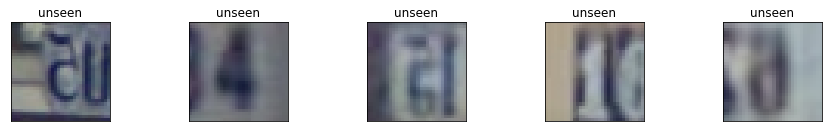

In [ ]:
class OpenSetSVHN(torch.utils.data.Dataset):
  '''Seen: CIFAR Closed set; Unseen: New Dataset'''

  def __init__(self, New_dataset_images, New_dataset_targets, transformFunc, OpenSetRec = False, MNIST = False):

    self.data = list()
    img2targets = list(zip(New_dataset_images, New_dataset_targets))

    for v in img2targets: 
      if not OpenSetRec: 
        self.data.append((v[0], 0)) # 0 is unseen
      else: 
        self.data.append((v[0], torch.tensor([0, 0])))
      
    
    self.transformFunc = transformFunc
    self.MNIST = MNIST
    print("Len of Entire Dataset {}".format(len(self.data)))
    
  def __getitem__(self, i):
    img, target = self.data[i]
    if type(img) != np.ndarray and self.MNIST: 
      # MNIST
      img = img.to(float)

      channel_1 = img.unsqueeze(0)
      channel_2 = channel_1.clone()
      channel_3 = channel_1.clone()
      
      img = torch.cat((channel_1, channel_2, channel_3), dim = 0)
      
      img = transforms.Resize(32)(img) 
      
    img = self.transformFunc(img)
    return img, target

  def __len__(self):
    return len(self.data)


train_OpenSetSVHN = OpenSetSVHN(torch.from_numpy(svhn_OEtrainset.data), torch.from_numpy(svhn_OEtrainset.labels), train_transform)
train_OpenSetSVHNLoader = torch.utils.data.DataLoader(train_OpenSetSVHN, batch_size = 16, shuffle = True)

mixed_classes = ["unseen", "seen"]
train_newDatasetAndCIFARiter = iter(train_OpenSetSVHNLoader)
imgs, targets = next(train_newDatasetAndCIFARiter)

imgs = imgs.numpy()
imgs -= imgs.min() 
imgs /= imgs.max()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(imgs[idx], (1, 2, 0)))
  ''' Choose one way to set titles'''

  '''Option 2:'''
  ax.set_title(mixed_classes[targets[idx]])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])


# For reference
# classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
              #'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

In [ ]:
eurosat_data = torchvision.datasets.EuroSAT("/content", download = True)
mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

class EuroSAT_Dataset(torch.utils.data.Dataset):
    def __init__(self, root):
      self.images = glob.glob(os.path.join(root, "2750", "*", "*.jpg"))   
      self.transform = transforms.Compose([transforms.ToPILImage(), 
                                           transforms.Resize(32), 
                                          transforms.ToTensor(), 
                                          transforms.Normalize(mean, std)])                          
    def __getitem__(self, i):
       image = cv2.cvtColor(cv2.imread(self.images[i]), cv2.COLOR_RGB2BGR)
       image = self.transform(image)

       return image, torch.tensor(0)

    def __len__(self):
      return len(self.images)
euro_dataset = EuroSAT_Dataset("/content/eurosat")
euro_dl = torch.utils.data.DataLoader(euro_dataset, batch_size = 32, shuffle = True)

  0%|          | 0/94280567 [00:00<?, ?it/s]

Extracting /content/eurosat/EuroSAT.zip to /content/eurosat


# One his now 
# Remove all BatchNorm layers
# Not only remove BatchNorm layers -> insert Dropout Layers
# Replace Lines 37 with Fully Connected Layer and then use Dropout
(Both have dropout and no dropout when removing Batch Norm)

 Use (x = torch.flatten(x, 1))

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)     
        

class Generator(nn.Module):
    def __init__(self, ngpu=1, nz=100, ngf=64, nc=512):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.nz = nz
        self.ngf = ngf
        self.nc = nc
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Conv2d( self.nz, self.ngf * 8, 1, 1, 0, bias=True),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),
            # state size. (self.ngf*8) x 4 x 4
            nn.Conv2d(self.ngf * 8, self.ngf * 4, 1, 1, 0, bias=True),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),
            # state size. (self.ngf*4) x 8 x 8
            nn.Conv2d( self.ngf * 4, self.ngf * 2, 1, 1, 0, bias=True),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),
            # state size. (self.ngf*2) x 16 x 16
            nn.Conv2d( self.ngf * 2, self.ngf*4, 1, 1, 0, bias=True),
            nn.BatchNorm2d(self.ngf*4),
            nn.ReLU(True),
            # state size. (self.ngf) x 32 x 32
            nn.Conv2d( self.ngf*4, self.nc, 1, 1, 0, bias=True),
            #nn.Tanh()
            # state size. (self.nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu=1, nc=2048, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.nc = nc
        self.ndf = ndf
        self.main = nn.Sequential(
            nn.Conv2d(self.nc, self.ndf*8, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*8, self.ndf*4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*4, self.ndf*2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*2, self.ndf, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class ResnetEncoder(nn.Module):
    """Pytorch module for a resnet encoder
    """
    def __init__(self, num_layers=18, isPretrained=False, isGrayscale=False, embDimension=128, poolSize=4):
        super(ResnetEncoder, self).__init__()
        self.path_to_model = '../models'
        self.num_ch_enc = np.array([64, 64, 128, 256, 512])
        self.isGrayscale = isGrayscale
        self.isPretrained = isPretrained
        self.embDimension = embDimension
        self.poolSize = poolSize
        self.featListName = ['layer0', 'layer1', 'layer2', 'layer3', 'layer4']
        
        resnets = {
            18: models.resnet18, 
            34: models.resnet34,
            50: models.resnet50, 
            101: models.resnet101,
            152: models.resnet152}
        
        resnets_pretrained_path = {
            18: 'resnet18-5c106cde.pth', 
            34: 'resnet34.pth',
            50: 'resnet50.pth',
            101: 'resnet101.pth',
            152: 'resnet152.pth'}

        if num_layers not in resnets:
            raise ValueError("{} is not a valid number of resnet layers".format(
                num_layers))

        self.encoder = resnets[num_layers]()
        
        if self.embDimension>0:
            self.encoder.linear =  nn.Linear(self.num_ch_enc[-1], self.embDimension)
        
        if self.isPretrained:
            print("using pretrained model")
            self.encoder.load_state_dict(
                torch.load(os.path.join(self.path_to_model, resnets_pretrained_path[num_layers])))
        
        #if self.isGrayscale:
        #    self.encoder.conv1 = nn.Conv2d(
        #        1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        #else:
        #    self.encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        
        if num_layers > 34:
            self.num_ch_enc[1:] *= 4

    def forward(self, input_image):
        self.features = []
        
        x = self.encoder.conv1(input_image)
        x = self.encoder.bn1(x)
        x = self.encoder.relu(x)
        self.features.append(x)
        
        #x = self.encoder.layer1(self.encoder.maxpool(x)) # 
        x = self.encoder.layer1(x) # self.encoder.maxpool(x)
        self.features.append(x)
        #print('layer1: ', x.shape)
        
        x = self.encoder.layer2(x)
        self.features.append(x)
        #print('layer2: ', x.shape)
        
        x = self.encoder.layer3(x) 
        self.features.append(x)
        #print('layer3: ', x.shape)       
        
        x = self.encoder.layer4(x)
        self.features.append(x)
        #print('layer4: ', x.shape)
        
        x = F.avg_pool2d(x, self.poolSize)
        #print('global pool: ', x.shape)
        
        x = x.view(x.size(0), -1)
        #print('reshape: ', x.shape)
        
        if self.embDimension>0:
            x = self.encoder.linear(x)
        #print('final: ', x.shape)
        return x
    

In [ ]:
def build_max_model(kway_model_path): 

  resnet50 = ResnetEncoder(num_layers = 50, embDimension = -1, poolSize=2)
  del resnet50.encoder.fc

  state_dict = torch.load(kway_model_path)
  new_keys = dict()
  for k in list(state_dict.keys()): 
    new_keys[k] = "encoder." + k
  
  modified_state_dict = dict((new_keys[key], value) for (key, value) in state_dict.items())

  del modified_state_dict['encoder.fc.weight']
  del modified_state_dict['encoder.fc.bias']

  resnet50.load_state_dict(modified_state_dict)
  resnet50.eval()

  return resnet50

# resnet50 = build_max_model("/content/drive/MyDrive/Unknown_Detection/Final_kWay10.pth")
resnet50 = build_max_model("/content/drive/MyDrive/Unknown_Detection/CIFAR50thepochOct3.pth")

# def build_max_model_18(kway_model_path): 

#   resnet18 = ResnetEncoder(embDimension = -1, poolSize=2)
#   del resnet18.encoder.fc

#   state_dict = torch.load(kway_model_path)
#   new_keys = dict()
#   for k in list(state_dict.keys()): 
#     new_keys[k] = "encoder." + k
  
#   modified_state_dict = dict((new_keys[key], value) for (key, value) in state_dict.items())

#   del modified_state_dict['encoder.fc.weight']
#   del modified_state_dict['encoder.fc.bias']

#   resnet18.load_state_dict(modified_state_dict)
#   resnet18.eval()

#   return resnet18

# resnet18 = build_max_model("/content/drive/MyDrive/Unknown_Detection/Final_kWay50.pth")

# Init Discriminator and Generator

In [ ]:
netG = Generator(ngpu=ngpu, nz=nz, ngf=ngf, nc=nc).to(device)
netD = Discriminator().to(device)
# netD = Discriminator(ngpu=ngpu, nc=nc, ndf=ndf).to(device)


# Handle multi-gpu if desired
if ('cuda' in device) and (ngpu > 1): 
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)


if ('cuda' in device) and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

print(device)

cuda


In [ ]:
noise = torch.randn(batch_size, nz, 1, 1, device=device)
# Generate fake image batch with G
fake = netG(noise)
print(fake.size()) 
predLabel = netD(fake)

print(noise.shape, fake.shape, predLabel.shape)

torch.Size([64, 2048, 1, 1])
torch.Size([64, 64, 1, 1]) torch.Size([64, 2048, 1, 1]) torch.Size([64, 1, 1, 1])


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish open and close labels
close_label = 1
open_label = 0

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0


# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr/1.5, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
from tarfile import XHDTYPE
# Training Loop

# Lists to keep track of progress
lossList = []
G_losses = []
D_losses = []

fake_BatchSize = int(ganBatchSize/2)
open_BatchSize = ganBatchSize

tmp_weights = torch.full((1,), 1, device=device).to(float)
tmp_weights[-fake_BatchSize:] *= weight_adversarialLoss
criterionD = nn.BCELoss(weight=tmp_weights)

netG.to(device)
netD.to(device) 
resnet50.to(device) 

print("Starting Training Loop...")
# For each epoch
openPixImgCount = 0
# openPix_sampler = iter(openPix_dataloader)
for epoch in range(num_epochs):
    print("New Epoch starting")
    # 32 is batch size for trainTinyImageNetLoader
    train_OpenSetSVHNLoader_iter = iter(train_OpenSetSVHNLoader)
    # For each batch in the dataloader
    for i, (images, labels) in enumerate(trainTinyImageNetLoader):
      # Trained Closed CIFAR is smaller than open SVHN
      open_images, open_labels = next(train_OpenSetSVHNLoader_iter)
      labels = torch.ones(*labels.size())

      ''' ADDED CODE'''
      noise_images = torch.from_numpy(np.random.normal(0, 1, size = (16, 3, 32, 32,))).float()
      noise_labels = open_labels.clone()
      
      images = torch.cat((images, noise_images), dim = 0)
      labels = torch.cat((labels, noise_labels), dim = 0)
      '''END'''
      images = torch.cat((images, open_images), dim = 0)
      labels = torch.cat((labels, open_labels), dim = 0)

      images = images.to(device)
      labels = labels.to(device)

      # Features to K Way classification Model (6 way classification) backbone 
      image_features = resnet50(images)[:, :, None, None]

      # generate fake images      
      noise = torch.randn(fake_BatchSize, nz, 1, 1, device=device)
      # Generate fake image batch with G
      label_fake = torch.full((fake_BatchSize,), fake_label, device=device)
      feat_fakeset = netG(noise)

      X = torch.cat((image_features, feat_fakeset), 0)
      label_total = F.pad(labels, pad = (0, int(ganBatchSize/2)), mode = 'constant', value = 0)[:, None, None]


      # X2label = list(zip(X, label_total))
      # random.shuffle(X2label)

      # X, label_total = list(zip(*X2label))
      # X, label_total = list(X), list(label_total)
      # X = torch.stack(X)
      # label_total = torch.stack(label_total)[:, None, None]

      ############################
      # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
      ###########################
      # using close&open&fake data to update D
      netD.zero_grad()
      output = netD(X).squeeze(-1)

      # output = torch.sigmoid(output)
      lossD = criterionD(output, label_total.float())
      lossD.backward(retain_graph=True)
      optimizerD.step()
      errD = lossD.mean().item()      
          
          
      ############################
      # (2) Update G network: maximize log(D(G(z)))
      ###########################
      netG.zero_grad()
      label_fakeclose = torch.full((fake_BatchSize,), close_label, device=device)  

      # Since we just updated D, perform another forward pass of all-fake batch through D
      output = netD(feat_fakeset).view(-1)
      # output = torch.sigmoid(output)

      # Calculate G's loss based on this output
      lossG = criterion(output, label_fakeclose.float())
      # Calculate gradients for G
      lossG.backward()
      errG = lossG.mean().item()
      # Update G
      optimizerG.step()
          
      # Save Losses for plotting later
      G_losses.append(errG)
      D_losses.append(errD)
      
      
      # Output training stats
      if i % 100 == 0:
          print('[%d/%d][%d/%d]\t\tlossG: %.4f, lossD: %.4f'
                % (epoch, num_epochs, i, len(train_OpenSetSVHNLoader), 
                    errG, errD))
            
            
    cur_model_wts = copy.deepcopy(netD.state_dict())
    path_to_save_paramOnly = os.path.join(save_dir, 'epoch-{}.classifier'.format(epoch+1))
    torch.save(cur_model_wts, path_to_save_paramOnly)
    cur_model_wts = copy.deepcopy(netG.state_dict())
    path_to_save_paramOnly = os.path.join(save_dir, 'epoch-{}.GNet'.format(epoch+1))
    torch.save(cur_model_wts, path_to_save_paramOnly)

# Evaluate OpenGAN Discriminator

In [ ]:
# Load Trained Discriminator

def load_discriminator(model_path): 
  discriminator = Discriminator()
  state_dict = torch.load(model_path)
  discriminator.load_state_dict(state_dict)
  discriminator.eval()
  discriminator.to(device) 

  return discriminator 


In [ ]:
def evaluate_bn_roc_pr(dis_model_path, kway_model_path, openDataset, closedDataset):

  disc = load_discriminator(dis_model_path)
  kway = build_max_model(kway_model_path)

  openDataLoader = torch.utils.data.DataLoader(openDataset, batch_size = 32, shuffle = True)
  closedDataLoader = torch.utils.data.DataLoader(closedDataset, batch_size = 32, shuffle = True)

  if len(openDataset) > len(closedDataset): 
    for_loop_loader = "closedDataLoader"
    iter_loader = "openDataLoader"
  else: 
    for_loop_loader = "openDataLoader"
    iter_loader = "closedDataLoader"
  
  print("For Loop Loader is {}".format(for_loop_loader))
  print("Iter Loop Loader is {}".format(iter_loader))

  '''Only will find ROC and PR Metrics'''

  disc = disc.cuda()
  kway = kway.cuda()

  stacked_outs = list()
  stacked_targets = list()

  dateiter = iter(eval(iter_loader))
  for for_data, for_targets in tqdm(eval(for_loop_loader)): 
      iter_data, iter_targets = next(dateiter)
      if for_loop_loader=="closedDataLoader": 
        for_targets = torch.ones(*for_targets.size())
        iter_targets = torch.zeros(*iter_targets.size())
      else: 
        for_targets = torch.zeros(*for_targets.size())
        iter_targets = torch.ones(*iter_targets.size())
      iter_data, iter_targets = iter_data.cuda(), iter_targets.cuda()
      for_data, for_targets = for_data.cuda(), for_targets.cuda()
      
      data = torch.cat((iter_data, for_data), 0)
      target = torch.cat((iter_targets, for_targets), 0)

      disc.eval()

      #forward
      x_feat = kway(data.float())[:, :, None, None]
      out = disc(x_feat)
      out = out.view(-1)

      assert out.size(0) == target.size(0)

      stacked_outs.extend(out.tolist()) 
      stacked_targets.extend(target.tolist()) # Only 0's and 1's
  
  roc_measure = roc(stacked_outs, stacked_targets)['auc'] * 100
  pr_measure = pr(stacked_outs, stacked_targets)['auc'] * 100

  print("\n")
  print("ROC AU value: {}%".format(roc_measure))
  print("PR AU value: {}%".format(pr_measure))

  return roc_measure, pr_measure

In [ ]:
test_OpenSetSVHN = OpenSetSVHN(torch.from_numpy(svhn_OEtestset.data), torch.from_numpy(svhn_OEtestset.labels), test_transform)

Len of Entire Dataset 26032


In [ ]:
testset_OpenSetCIFAR = CIFAR10(root='./data', train=False, download=True)

Files already downloaded and verified


In [ ]:
from torchvision.datasets import EuroSAT
test_OpenSetEuroSAT = EuroSAT(root = './data', download = True)

  0%|          | 0/94280567 [00:00<?, ?it/s]

Extracting ./data/eurosat/EuroSAT.zip to ./data/eurosat


# Could be massively overfitting need to check on other validations

In [ ]:
evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/OPenGANTestTinyImageNetNotPretrainedSep5th.classifier", 
                   "/content/drive/MyDrive/Unknown_Detection/50EpochsFullTrainTinyImageNetAug27th.pth", 
                   test_OpenSetMNIST, testTinyImageNet)

For Loop Loader is closedDataLoader
Iter Loop Loader is openDataLoader


100%|██████████| 282/282 [00:14<00:00, 18.98it/s]




ROC AU value: 33.79420003447596%
PR AU value: 46.475967846128235%


(33.79420003447596, 46.475967846128235)

In [ ]:
# euro_dataset
import cv2
evaluate_bn_roc_pr("/content/drive/MyDrive/Unknown_Detection/OPenGANTestTinyImageNetNotPretrainedSep5th.classifier", 
                   "/content/drive/MyDrive/Unknown_Detection/50EpochsFullTrainTinyImageNetAug27th.pth", 
                   euro_dataset, testTinyImageNet)

For Loop Loader is closedDataLoader
Iter Loop Loader is openDataLoader


100%|██████████| 282/282 [00:15<00:00, 18.11it/s]



ROC AU value: 92.43709613869189%
PR AU value: 92.38217617458508%


(92.43709613869189, 92.38217617458508)

In [ ]:
evaluate_bn_roc_pr("/content/OpenGAN/exp/demo_step030_OpenGAN_num1000_w0.20/epoch-20.classifier", 
                   "/content/drive/MyDrive/Unknown_Detection/50EpochsFullTrainTinyImageNetAug27th.pth", 
                   test_OpenSetSVHN, testTinyImageNet)

For Loop Loader is closedDataLoader
Iter Loop Loader is openDataLoader


100%|██████████| 282/282 [00:13<00:00, 20.23it/s]



ROC AU value: 99.965035214736%
PR AU value: 99.96569362127879%


(99.965035214736, 99.96569362127879)

In [ ]:
evaluate_bn_roc_pr("/content/OpenGAN/exp/demo_step030_OpenGAN_num1000_w0.20/epoch-20.classifier", 
                   "/content/drive/MyDrive/Unknown_Detection/50KWayModelAugust21.pth", 
                   test_closedset_CIFAR, testTinyImageNet)

For Loop Loader is openDataLoader
Iter Loop Loader is closedDataLoader


100%|██████████| 188/188 [00:08<00:00, 23.07it/s]



ROC AU value: 89.08872866799645%
PR AU value: 86.23262546060755%


(89.08872866799645, 86.23262546060755)

In [ ]:
evaluate_bn_roc_pr("/content/OpenGAN/exp/demo_step030_OpenGAN_num1000_w0.20/epoch-20.classifier", 
                   "/content/drive/MyDrive/Unknown_Detection/Final_kWay10.pth", 
                   test_closedset_CIFAR, testTinyImageNet)

For Loop Loader is openDataLoader
Iter Loop Loader is closedDataLoader


100%|██████████| 188/188 [00:08<00:00, 22.03it/s]



ROC AU value: 55.60331477171986%
PR AU value: 55.87801505132166%


(55.60331477171986, 55.87801505132166)

In [ ]:
evaluate_bn_roc_pr("/content/OpenGAN/exp/demo_step030_OpenGAN_num1000_w0.20/epoch-15.classifier", 
                   "/content/drive/MyDrive/Unknown_Detection/Final_kWay10.pth", 
                   heavy_Transforms_CIFAR, testTinyImageNet)

For Loop Loader is closedDataLoader
Iter Loop Loader is openDataLoader


100%|██████████| 282/282 [01:17<00:00,  3.66it/s]



ROC AU value: 84.7548721926714%
PR AU value: 86.37322143721642%


(84.7548721926714, 86.37322143721642)

In [ ]:
evaluate_bn_roc_pr("/content/OpenGAN/exp/demo_step030_OpenGAN_num1000_w0.20/epoch-13.classifier", 
                   "/content/drive/MyDrive/Unknown_Detection/Final_kWay10.pth", 
                   test_OpenSetMNIST, testTinyImageNet)

For Loop Loader is closedDataLoader
Iter Loop Loader is openDataLoader


100%|██████████| 1125/1125 [00:24<00:00, 46.33it/s]




ROC AU value: 79.29610555555556%
PR AU value: 82.38180214732527%


(79.29610555555556, 82.38180214732527)

In [ ]:
evaluate_bn_roc_pr("/content/OpenGAN/exp/demo_step030_OpenGAN_num1000_w0.20/epoch-13.classifier", 
                   "/content/drive/MyDrive/Unknown_Detection/Final_kWay10.pth", 
                   test_OpenSetMNIST, testTinyImageNet)

For Loop Loader is closedDataLoader
Iter Loop Loader is openDataLoader


100%|██████████| 1125/1125 [00:31<00:00, 35.29it/s]




ROC AU value: 79.6186574074074%
PR AU value: 82.65972034942249%


(79.6186574074074, 82.65972034942249)

In [ ]:
evaluate_bn_roc_pr("/content/OpenGAN/exp/demo_step030_OpenGAN_num1000_w0.20/epoch-10.classifier", 
                   "/content/drive/MyDrive/Unknown_Detection/Final_kWay50.pth", 
                   test_OpenSetMNIST, testTinyImageNet)

For Loop Loader is closedDataLoader
Iter Loop Loader is openDataLoader


100%|██████████| 563/563 [00:13<00:00, 42.91it/s]




ROC AU value: 31.609109803631334%
PR AU value: 44.063480140476116%


(31.609109803631334, 44.063480140476116)

In [ ]:
test_OpenSetMNIST = OpenSetSVHN(mnist_OEtestset.data, mnist_OEtestset.targets, test_transform, MNIST = True)
# train_OpenSetSVHNLoader = torch.utils.data.DataLoader(train_OpenSetSVHN, batch_size = 16, shuffle = True)

Len of Entire Dataset 10000


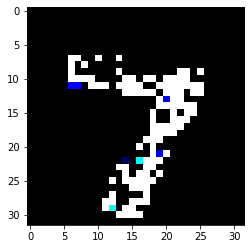

In [ ]:
plt.imshow(train_OpenSetMNIST[0][0].permute(1, 2, 0) * 255)

In [ ]:
[-1]

In [ ]:
class SplitCIFAR(torch.utils.data.Dataset):
    def __init__(self, data, targets, split, mode, transformFunc, iaa_compat = False, rain = False):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        img2targets = list(zip(data, targets))
        self.data = list()
        self.iaa_compat = iaa_compat
        self.rain = rain

        if mode == "train": 
          for v in img2targets:
            _, target = v
            if target < split: 
              self.data.append(v)
        elif mode == "test": 
          for v in img2targets: 
            _, target = v 
            if target >= split: 
              self.data.append(v)
        else: 
          raise ValueError("Not a mode")
        
        self.transformFunc = transformFunc

        if self.iaa_compat: 
          self.contents = ["UNSEEN"] * (len(self.data) // 2)
          left = len(self.data) - len(self.contents)
          self.contents.extend((["SEEN"] * left))

          assert len(self.contents) == len(self.data)

          self.normal_transform = transforms.Compose([
                                                      transforms.ToPILImage(), 
                                                      transforms.ToTensor(), 
                                                      transforms.Normalize(mean, std)])                             
    def __getitem__(self, i):
       img, target = self.data[i]
       if self.iaa_compat: 
         if self.contents[i] == "UNSEEN":
           img = self.transformFunc(image = img)
           target = torch.tensor(0, dtype = int)
         else: 
           '''SEEN data'''
           if self.rain: 
             img = self.transformFunc(image = img)
           target = torch.tensor(1, dtype = int)

         img = self.normal_transform(img)
         return img, target 
       else: 
         img = self.transformFunc(img)
         return img, target

    def __len__(self):
        return len(self.data)

batch_size = 32

split = 6
testset = CIFAR10(root='./data', train=False, download=True)
test_transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)
])
test_closedset_CIFAR = SplitCIFAR(testset.data, testset.targets, split, "train", test_transform)
len(test_closedset_CIFAR)

Files already downloaded and verified


6000

In [ ]:
!pip install git+https://github.com/aleju/imgaug.git
import imgaug.augmenters as iaa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-yugtuhm_
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-yugtuhm_


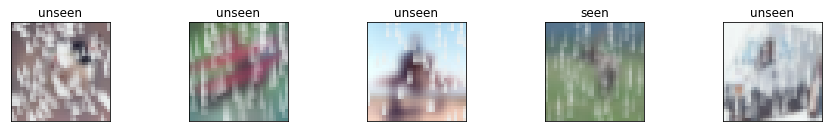

In [ ]:
transforms_noisyOE = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.pillike.EnhanceContrast(), 
    iaa.GaussianBlur(sigma=(0.1, 2)), 
    iaa.Rain(speed=(0.1, 0.3))
])

heavy_Transforms_CIFAR = SplitCIFAR(testset.data, testset.targets, 10, "train", transforms_noisyOE, iaa_compat = True, rain = True)
closed_set_heavy_TransformsLoader = torch.utils.data.DataLoader(heavy_Transforms_CIFAR, batch_size = batch_size, shuffle = True)

noiseRegIter = iter(closed_set_heavy_TransformsLoader)
imgs, targets = next(noiseRegIter)
imgs = imgs.float()
imgs -= imgs.min()
imgs /= imgs.max()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(imgs[idx], (1, 2, 0)))
  ax.set_title(mixed_classes[targets[idx]])
  ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])

In [ ]:
def validate_OpenGAN_on_noise(dis_model_path, kway_model_path, datasets, noise_type): 

  disc = load_discriminator(dis_model_path)
  kway = build_max_model(kway_model_path)

  DataLoader = torch.utils.data.DataLoader(datasets, batch_size = 32, shuffle = True)

  '''Only will find ROC and PR Metrics'''

  disc = disc.cuda()
  kway = kway.cuda()

  stacked_outs = list()
  stacked_targets = list()

  dateiter = iter(DataLoader)
  for i in tqdm(range(300)):
    if (i % 2) == 0: 
      images, targets = next(dateiter)
      images = images[0]
      images = images.unsqueeze(0)
      targets = torch.ones(1)
    else: 
      if noise_type == "normal": 
        mu, sigma = 0, 1
        images = torch.from_numpy(np.random.normal(mu, sigma, size = (1, 3, 32, 32)))
      elif noise_type == "uniform": 
        mu, sigma = 0, 1
        images = torch.from_numpy(np.random.uniform(mu, sigma, size = (1, 3, 32, 32)))
      targets = torch.zeros(1)

    images = images.cuda()
    targets = targets.cuda()
    
    disc.eval()

    #forward
    x_feat = kway(images.float())[:, :, None, None]
    out = disc(x_feat)
    out = out.view(-1)

    assert out.size(0) == targets.size(0)

    stacked_outs.extend(out.tolist()) 
    stacked_targets.extend(targets.tolist()) # Only 0's and 1's
  
  roc_measure = roc(stacked_outs, stacked_targets)['auc'] * 100
  pr_measure = pr(stacked_outs, stacked_targets)['auc'] * 100

  print("\n")
  print("ROC AU value: {}%".format(roc_measure))
  print("PR AU value: {}%".format(pr_measure))

  return roc_measure, pr_measure


In [ ]:
def validate_logits_on_noise(kway_model_path, datasets, noise_type, form): 

  kway = build_max_model(kway_model_path)

  DataLoader = torch.utils.data.DataLoader(datasets, batch_size = 32, shuffle = True)

  '''Only will find ROC and PR Metrics'''

  kway = kway.cuda()

  stacked_outs = list()
  stacked_targets = list()

  dateiter = iter(DataLoader)
  for i in tqdm(range(563)):
    if (i % 2) == 0: 
      images, targets = next(dateiter)
      images = images[0]
      images = images.unsqueeze(0)
      targets = torch.ones(1)
    else: 
      if noise_type == "normal": 
        mu, sigma = 0, 1
        images = torch.from_numpy(np.random.normal(mu, sigma, size = (1, 3, 32, 32)))
      elif noise_type == "uniform": 
        mu, sigma = 0, 1
        images = torch.from_numpy(np.random.uniform(mu, sigma, size = (1, 3, 32, 32)))
      targets = torch.zeros(1)

    images = images.cuda()
    targets = targets.cuda()

    #forward
    x = kway(images.float())
    if form == "softmax":
      # Softmax Probability
      x = F.softmax(x, dim=1)
      assert sum(x[0]).item() > 0.99 and sum(x[0]).item() < 1.001
    
    max = torch.max(x, dim = 1).values

    stacked_outs.extend(max.tolist()) 
    stacked_targets.extend(targets.tolist()) # Only 0's and 1's
  
  roc_measure = roc(stacked_outs, stacked_targets)['auc'] * 100
  pr_measure = pr(stacked_outs, stacked_targets)['auc'] * 100

  print("\n")
  print("ROC AU value: {}%".format(roc_measure))
  print("PR AU value: {}%".format(pr_measure))

  return roc_measure, pr_measure


In [ ]:
validate_logits_on_noise("/content/drive/MyDrive/Unknown_Detection/model_epoch15.pth", test_closedset_CIFAR, "uniform", "softmax")

100%|██████████| 563/563 [00:07<00:00, 75.60it/s]



ROC AU value: 68.40942934302517%
PR AU value: 79.99738506777474%


(68.40942934302517, 79.99738506777474)

In [ ]:

validate_OpenGAN_on_noise("/content/drive/MyDrive/Unknown_Detection/OPenGANTestTinyImageNetNotPretrainedSep5th.classifier", "/content/drive/MyDrive/Unknown_Detection/50EpochsFullTrainTinyImageNetAug27th.pth", testTinyImageNet, "normal")

100%|██████████| 563/563 [00:11<00:00, 51.00it/s]



ROC AU value: 100.0%
PR AU value: 100.0%


(100.0, 100.0)

In [ ]:
validate_OpenGAN_on_noise("/content/drive/MyDrive/Unknown_Detection/20epochOpenGANCIFARKwayOct6th.pth", "/content/drive/MyDrive/Unknown_Detection/CIFAR50thepochOct3.pth", test_closedset_CIFAR, "uniform")

100%|██████████| 300/300 [00:04<00:00, 63.80it/s]



ROC AU value: 93.68888888888887%
PR AU value: 96.28526191042559%


(93.68888888888887, 96.28526191042559)